In [23]:
!pip install datasets transformers[sentencepiece]
!pip install wandb --upgrade
!pip install streamlit

In [24]:
import torch.nn as nn
from datasets import load_dataset
import numpy as np
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from datasets import load_metric
import torch.nn.functional as F
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from matplotlib import pyplot as plt
import nltk
from torch.optim.lr_scheduler import ConstantLR, StepLR, ExponentialLR, ReduceLROnPlateau 
nltk.download('punkt')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import wandb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
wandb.login()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Model architecture


In [25]:
class FastGRU(nn.Module):
  """GRU
  
      Args:
        x : input of shape (batch_size, seq_len, input_size)
        h : last h of size (batch_size, hidden_size)

      Returns:
        all_hidden : output of shape (batch_size, seq_len, hidden_size)
  """
  def __init__(self, input_size, hidden_size):
      super().__init__()
      self.hidden_size = hidden_size
      self.update = nn.Linear(input_size + hidden_size, hidden_size)
      self.reset = nn.Linear(input_size + hidden_size, hidden_size)
      self.memory_Wx = nn.Linear(input_size, hidden_size) 
      self.memory_Uh_1 = nn.Linear(hidden_size, hidden_size)
     
  def forward(self, x, h):
      allhidden = torch.zeros(x.shape[0], x.shape[1], self.hidden_size, device=x.device)
      for i, word in enumerate(x.unbind(dim = 1)):
          # Update gate
          z = torch.cat((word, h), 1)
          zt = nn.functional.sigmoid(self.update(z))
          
          # Reset gate
          r = torch.cat((word, h), 1)
          rt = nn.functional.sigmoid(self.reset(r))
          
          # New memory
          h1 = self.memory_Wx(word)
          h2 = self.memory_Uh_1(h)
          ht = nn.functional.tanh(rt * h2 + h1)
          # Hidden state
          ht = (1 - zt) * ht + zt + h
          h = ht
          allhidden[:, i, :] = h
      return allhidden

In [26]:
class Dropout(nn.Module):
  """Dropout

  Arguments :
    x (FloatTensor) : Input of shape (batch_size, seq_len, hidden_size)
    p (Float) : Dropout parameter. The neuron is active with probability p and inactive otherwise.
  Return : 
    x (FloatTensor) : Input of shape (batch_size, seq_len, hidden_size) with dropouts

  """
  def __init__(self, dropout):
      super().__init__()
      self.p = dropout
  
  def forward(self, x):
      if self.p != 0: # comparing with floats can be tricky sometimes.
          mask = (torch.rand(*x.shape, device=x.device) < self.p) / self.p
          out = mask * x
          return out
      return x

In [27]:
class FastGRUTextClassification(nn.Module):
  """GRU with text classification head

    Args:
      x : input of shape (batch_size, seq_len)

    Returns:
      x : Hidden states of shape (batch_size, seq_len, hidden_size)
      output : output of shape (batch_size, seq_len, num_labels)
  """
  def __init__(self, input_size, hidden_size, vocab_size, n_labels, num_layers, dropout):
      super().__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.gru_layers = nn.ModuleList([FastGRU(input_size, hidden_size) for i in range(num_layers)])
      self.h = nn.Parameter(torch.rand(self.hidden_size))
      self.embedding = nn.Embedding(vocab_size, input_size)
      self.proj_head = nn.Linear(hidden_size, n_labels)
      self.dropout = Dropout(dropout)
      self.training = True # check pytorch has some variable for this
  
  def eval(self):
      self.training = False
      return self

  def forward(self, x):
      x = self.embedding(x) 
      h = self.h.expand(x.shape[0], self.hidden_size)

      for index, grulayer in enumerate(self.gru_layers):
        x = grulayer(x, h)
        if  (self.num_layers - index) > 1 and self.training:
          x = self.dropout(x)
          
      output = self.proj_head(x)
      return x, output

# Importing libraries

# 1. Linear Model for Baseline

In [28]:
# # Linear Model Baseline

# Data
def linear_model():
    raw_datasets = load_dataset("ag_news")
    train_data = raw_datasets['train']#.select(range(100))
    test_data = raw_datasets['test']#.select(range(100))

    # Taking a small sample
    raw_datasets['train'] = train_data
    raw_datasets['test'] = test_data

    # tfidf vectorizer
    vectorizer = TfidfVectorizer()
    input = vectorizer.fit_transform(raw_datasets['train']['text']) # encoding for text

    model = LogisticRegression().fit(input, raw_datasets['train']['label'])
    y_pred = model.predict(vectorizer.transform(raw_datasets['test']['text']))

    print("Test accuracy is : ", accuracy_score(raw_datasets['test']['label'], y_pred))
    print("F1 macro is : ", f1_score(raw_datasets['test']['label'], y_pred, average='macro'))

# 2. Training GRU model

In [29]:
# Loading dataset
raw_datasets = load_dataset("ag_news")
train_data = raw_datasets['train']#.shuffle(seed=35).select(range(20))
val_data = train_data.train_test_split(test_size=0.08)
test_data = raw_datasets['test']#.shuffle(seed=35).select(range(5))

# Taking a small sample
raw_datasets['train'] = val_data['train']
raw_datasets['val'] = val_data['test']

# Tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True)

# Tokenize the raw data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 110400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 9600
    })
})

**TOkenize**

In [31]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Pre process the tokenized data for dataloader to create batch
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

  0%|          | 0/111 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-7e7715a750b945f6.arrow


  0%|          | 0/10 [00:00<?, ?ba/s]

**Plotting text length distribution**

In [32]:
def create_text_len_plots(tokenized_datasets):
    """Create three plots for train, val abd test set with x axis as length of the tokenized input and y axis as number of inputs.
    Arguments:
      raw_datasets : tokenized dataset
      """
    training_set_length = []
    for input_ids in tokenized_datasets['train']["input_ids"]:
      training_set_length.append(len(input_ids))

    val_set_length = []
    for input_ids in tokenized_datasets['val']["input_ids"]:
      val_set_length.append(len(input_ids))

    test_set_length = []
    for input_ids in tokenized_datasets['test']["input_ids"]:
      test_set_length.append(len(input_ids))

    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
    axs[0].hist(training_set_length, bins=30)
    axs[1].hist(val_set_length, bins=30)
    axs[2].hist(test_set_length, bins=30)

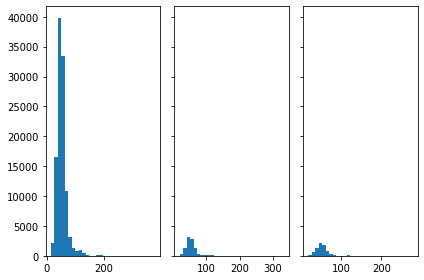

In [33]:
create_text_len_plots(tokenized_datasets)

In [34]:
# Check data distribution
def create_data_dictribution_plot(raw_datasets):
    """Create three plots for train, val abd test set with x axis as label ids and y axis as number of labels.
    Arguments:
      raw_datasets : Dataobject
    """

    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
    axs[0].hist(raw_datasets['train']['label'], bins=30)
    axs[1].hist(raw_datasets['val']['label'], bins=30)
    axs[2].hist(raw_datasets['test']['label'] , bins=30)

**Training and evaluation loop**

In [35]:
def batch_evaluate(batch, model, flag):
    """
    Computes the predictions, number of correct answers and loss

    Arguments:
      batch : batch from data loaders
      model : model 
      flag : Flag set to 'train' if it is in training mode. 'val' if it is in validation mode and 'test' for test mode.

    Returns:
      loss : if train is True then loss is returned else None
    """
    y_pred = []
    wandb.watch(model, log="all", log_freq=10)
    batch = {key: values.to(device) for key, values in batch.items()}

    # Getting the end of sentences for each sentence in a batch
    sent_end = []
    for item in batch["input_ids"]:
      index = (item == 0).nonzero(as_tuple=True)[0]
      if len(index) != 0:
          index = index[0].item() - 1 
      else:
          index = len(item) - 1
      sent_end.append(index)
    sent_end = torch.as_tensor(sent_end).to(device)

    # Model input and output
    hidden_states, output = model(batch["input_ids"])
    
    # prediction and loss
    prediction_logits = output.gather(1, sent_end.reshape(len(batch["input_ids"]), 1).repeat(1, output.shape[2]).view(len(batch["input_ids"]), 1, output.shape[2])) 
    # prediction_logits shape (batch_size, 1, nums_labels)

    loss = F.cross_entropy(prediction_logits.squeeze(1), batch["labels"])

    predictions = torch.argmax(prediction_logits, dim=-1) # shape (batch_size, 1)
    y_true = batch["labels"]
    
    correct = (predictions.squeeze(1) == y_true).sum()
        
    if flag is 'train':    
        wandb.log({"training loss": loss, "batch training accuracy ": correct/len(y_true)})
        return loss
    elif flag is 'val':
        wandb.log({"validation loss": loss, "validation accuracy ": correct/len(y_true)})
    elif flag is 'test':
        wandb.log({"test accuracy ": correct/len(y_true)})
    else:
      print("enter the correct flag value. It must be one of these 'train', 'val, 'test'")

In [36]:
def train(tokenized_datasets, data_collator): 
    NUM_WORKERS = 8
    NUM_LABELS = 4

    config = {"train_batch_size": 512, 
              "val_batch_size": len(tokenized_datasets['val']),  # whole val set
              "test_batch_size": len(tokenized_datasets['test']), # whole test set
              "input_size": 256, 
              "hidden_size": 256, 
              "num_labels": NUM_LABELS, 
              "gru_num_layers": 2, 
              "dropout": 0,
              "epochs": 5, 
              "lr": 0.000275} 

    # Dataloader
    train_dataloader = DataLoader(tokenized_datasets["train"], 
                                  batch_size=config["train_batch_size"], 
                                  num_workers=NUM_WORKERS, 
                                  collate_fn=data_collator)

    val_dataloader = DataLoader(tokenized_datasets["val"], batch_size=config["val_batch_size"], num_workers=NUM_WORKERS, collate_fn=data_collator)
    test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=config["test_batch_size"], num_workers=NUM_WORKERS, collate_fn=data_collator)

    # Model
    model = FastGRUTextClassification(input_size=config["input_size"], 
                                      hidden_size=config["hidden_size"], 
                                      vocab_size=tokenizer.vocab_size, 
                                      n_labels=config["num_labels"], 
                                      num_layers=config["gru_num_layers"], 
                                      dropout=config["dropout"]).to(device=device)


    # Set up
    with wandb.init(project="ag_news_GRU_v21", config= config):
        num_epochs = config["epochs"]
        num_labels = NUM_LABELS # change it into constant
        num_training_steps = num_epochs * len(train_dataloader)
        optimizer = AdamW(model.parameters(), betas=(0.9, 0.99), eps=1e-7, lr=config["lr"])
        lr_scheduler = StepLR(optimizer, step_size=num_training_steps)
        progress_bar = tqdm(range(num_training_steps))

        # Training loop
        wandb.watch(model, log="all", log_freq=10)
        for epoch in range(num_epochs):
            model.train()
            for batch in train_dataloader:
                batch = {key: values.to(device) for key, values in batch.items()}
                # back propogation and updates
                loss = batch_evaluate(batch, model, flag='train')
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad() # otherwise gradients get added up
                progress_bar.update(1)

            # Validation evaluation loop
            model.eval()
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.no_grad():
                    batch_evaluate(batch, model, flag='val')
                    
        model.eval()
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
              batch_evaluate(batch, model, flag='test')

      #wandb.save("model.onnx")

In [38]:
def inference(input, model, tokenizer): # model.train()
    """ Return label for given input
    Arguments:
      input (list) : list of strings
      model
      tokenizer
    
    Return:
      label (str) : lebls will be {0:'World', 1:'Sports', 2:'Business', 3:'Sci/Tech'}
    """
    model.eval()
    class_map = {0:'World', 1:'Sports', 2:'Business', 3:'Sci/Tech'}
    input = tokenizer(input)
    label = []
    for i in range(len(input["input_ids"])):
      _, output = model(torch.tensor([input["input_ids"][i]]).to(device))
      label.append(torch.argmax(output[:, -1, :]).item())
      label = [class_map[x] for x in label]
    return label

In [39]:
def main():
    # Loading dataset
    raw_datasets = load_dataset("ag_news")
    train_data = raw_datasets['train']#.shuffle(seed=35).select(range(20))
    val_data = train_data.train_test_split(test_size=0.08) # creating validation set
    test_data = raw_datasets['test']#.shuffle(seed=35).select(range(5))

    # Taking a small sample
    raw_datasets['train'] = val_data['train']
    raw_datasets['val'] = val_data['test']

    # check distribution of data
    create_data_dictribution_plot(raw_datasets)

    # Tokenizer
    checkpoint = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True)

    # Tokenize the raw data
    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True)

    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

    # Add padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Pre process the tokenized data for dataloader to create batch
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Creating text length distribution plots
    create_text_len_plots(tokenized_datasets)

    print("Training---->")
    train(tokenized_datasets, data_collator)

  


In [ ]:
if __name__ == "__main__":
    main()

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-2a9cc4050d5a3125.arrow and /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-69f6705fed4d40cf.arrow


  0%|          | 0/111 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1080 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
#  dir(model)

In [ ]:
# turn off all regularization and overfit.

# Miscellaneous 

In [ ]:
x = torch.tensor([[  101,  1012,   102,     0,     0,     0],
                  [  101,   102,     0,     0,      0,    0 ],
                  [  101,  1012,  1998,  2062,  1012,   102],
                  [  101,  1032, 2149, 19961,   102,     0]])

In [ ]:
sent_end = []
for item in x:
  index = (item == 0).nonzero(as_tuple=True)[0]
  if len(index) != 0:
   index = index[0].item() -1 
  else:
    index = len(item)-1
  sent_end.append(index)

In [ ]:
sent_end

In [ ]:
sent_end = torch.tensor(sent_end)

In [ ]:
sent_end

In [ ]:
y = torch.rand(4,6,3)

In [ ]:
y 

In [ ]:
y.gather(1, sent_end.reshape(4,1).repeat(1,3).view(4, 1, 3))
# y.gather(1, sent_end.reshape(batch_size,1).repeat(1,y.shape[2]).view(batch_size, 1, y.shape[2]))

In [ ]:
sent_end.reshape(4,1).repeat(1,6).view(4, 1, 6)

In [ ]:
m = torch.randn(4,2,3)
ids = torch.Tensor([1,1,0,0]).long()
print(m.gather(1, ids.reshape(4,1).repeat(1,3).view(4, 1, 3)))

In [ ]:
print(m)
print(ids)
print(ids.reshape(4,1).repeat(1,3).view(4, 1, 3))

In [ ]:
z = ids.repeat(0,3)

In [ ]:
ids = torch.randint(0, 3, size=(4, 1))
print(ids)
idx = ids.repeat(1, 3).view(4, 1, 3)

In [ ]:
idx

In [ ]:
torch.Tensor([1,1,0,0]).long().shape

In [ ]:
import pandas as pd

In [ ]:
from locale import D_FMT
df = pd.DataFrame(columns=["id"])

In [ ]:
df

In [ ]:
df["id"] = ['A1',"B1","p", "a","anb"]

In [ ]:

df

In [ ]:
df[df.id != 'A']

In [ ]:
for i, rows in df.iterrows():
  print(rows[0])
  if rows[0].startswith('A') or rows[0].startswith('B'):
    continue
  else:
    df = df.drop([i])


In [ ]:
df